<a href="https://colab.research.google.com/github/jiinjung/lunar-spectroscopy-toolkit/blob/main/OpticalConstants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved 
FOLDERNAME = "lunar-spectroscopy"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that the Python interpreter of the Colab VM can load
import sys
syspath = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(syspath)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# 1) Basic Functions and Tools for Radiative Transfer Models
(note that this part is the same as the #1 of refSSA.ipynb)


The following are the five basic Hapke radiative transfer model functions and calculation tools for converting reflectance to single scattering albedo: 


1) **Chandrasekhar(w , x)** : This function calculates Chandrasekar H function from Hapke radiative tranfer model
    Inputs: 1) w = SSA, 2) x = mu or mu_0
    Output: 1) H = corresponding Chandrasekar H-function

2) **phaseFunction(g)**: This function calculates phase function in the Hapke radiative transfer model, that how reflected energy changes with viewing directions. The value are from Pieters and Li lunar spectroscopy papers
    Inputs: 1) g = phase angle
    Outputs: 1) P(g) = phase function 
    
3) **backscatterFunction(g)**: This function calculates backscatter function in the Hapke radiative transfer model
    Inputs: 1) g = phase angle
    Outputs: 1) B(g) = backscattering function

4) **bisection (func, a, b, tolerance)**: This function takes function, initial input a, b and tolerance tol, and find the root based on the bisection method.
    Inputs: 1) func = function to find a root of zero 2) a = lowerlimit of the bisection range 3) b = upperlimit of the bisection range 4) tolerance 
    Outputs: 1) numerical answer from the bisection algorithm
    
5) **ssa2ref(w, mu_0, mu)**: This function calculates reflectance from the given SSA value
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles
    Output: 1) r = corresponding reflectance 


The Hapke radiative transfer model describes that the spectral reflectance relates to the single-scattering albedo (SSA) of mineral constituents.

\begin{align}
r = \frac{w}{4(\mu + \mu_0)}[(1 + B(g))P(g) + H(w, \mu)H(w, \mu_0) - 1],
\end{align}


where $w$, $\mu$, $\mu_0$, and $g$ are SSA, cosine of an incidence angle, and cosine of an emittance angle, respectively. $B$ is the backscattering function, $P$ is the phase function, and $H$ is the Chandrasekhar integral function. 

We can assume $B = 0$ (no backscattering at the phase angle measured), and $P = 1$ (isotropic scatters) for laboratory measurements, which gives:

\begin{align}
r = \frac{w}{4(\mu + \mu_0)} H(w, \mu)H(w, \mu_0),
\end{align}

For the latter case, function 3) and 4) will not be used.

In [6]:
def Chandrasekhar(w , x):
    """
    This function calculates Chandrasekar H function from Hapke radiative tranfer model
    Inputs: 1) w = SSA, 2) x = mu or mu_0
    Output: 1) H = corresponding Chandrasekar H-function
    """

    gamma = np.sqrt(1 - w)
    r0 = (1 - gamma)/(1 + gamma)
    H = (1 - w * x * (r0 + (1 - 2 * r0 * x)/2 * np.log((1 + x) / x)))**(-1);
    
    return H

In [7]:
def phaseFunction(g):
    """
    This function calculates phase function in the Hapke radiative transfer model, that how reflected energy changes 
    with viewing directions. The value are from Pieters and Li lunar spectroscopy papers
    Inputs: 1) g = phase angle
    Ouputs: 1) P(g) = phase function
    """
    b = -0.4
    c = 0.25
    
    p_g = 1 + b * np.cos(np.radians(g)) + c * (1.5 * np.cos(np.radians(g))**2 - 0.5)
    
    return p_g

In [8]:
def backscatterFunction(g):
    """
    This function calculates backscatter function in the Hapke radiative transfer model
    Inputs: 1) g = phase angle
    Ouputs: 1) B(g) = backscattering function
    """
    
    h = -3/8 * np.log(1 - 0.41) 
    
    return 1 / (1 + (1/h)) * np.tan(np.radians(g / 2))

In [9]:
def bisection(func, a, b, tol): 
    """
    This function takes function, initial input a, b and tolerance tol,
    and find the root based on the bisection method 
    """
    fa = func(a)
    fb = func(b)
    
    if np.sign(fa) == np.sign(fb) or np.isnan(fa) or np.isnan(fb):
        print("error: root not bracketed or function is NaN at endpoint")
        return 0
    
    # to crate lists for tracking value
    _iter = []
    _err_abs = []
    _a = []
    _p = []
    _b = []
    
    i = 0 
    # to loop while the absolute error is more than the tolerance
    while (b - a) > tol: 
        
        # to implement bisection algorithm
        i = i + 1 
        p = (a + b)/2 # midpoint
        fp = func(p)
        
        # to add value to the lists
        _iter.append(i)
        _err_abs.append(b - a)
        _a.append(a)
        _p.append(p)
        _b.append(b)
        
        # to update a and b
        if np.sign(fp) == np.sign(fa):
            a = p
        else:
            b = p
    
    return p

In [31]:
def ssa2ref(w, mu_0, mu, g):
    """
    This function calculates reflectance from the given SSA value
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles
    Output: 1) r = corresponding reflectance 
    """
    # Calculates Chandrasekhar of the mixture
    H_mu0 = Chandrasekhar(w, mu_0)
    H_mu = Chandrasekhar(w, mu)

    # Calculates reflectance of the mixture 
    #r = w / 4 / (mu_0 + mu) * ((1 + B(g)) * p(g) + H_mu0 * H_mu - 1) 
    
    # Calculates reflectance of the mixture assuming B = 0 (no backscattering) and P = 1 (isotropic scatter)
    r = w / 4 / (mu_0 + mu) * H_mu0 * H_mu
    
    return r

# 2) Hapke Radiative Transfer Model (SSA and Optical constants)

Here we define a series of radiative transfer equations described in [Hapke, 1981]

1) **ssa(se, si, th)** : This ssa function calculates single scattering albedo based on Hapke, 1981 model. Inputs: 1) se = the surface reflection coefficient, 2) si = the internally scattered light, 3) th = reflection coefficient; Ouputs: 1) ssa = single scattering albedo

\begin{align}
w = S_e + (1-S_e)\frac{1-S_i}{1-S_i\theta}\theta,
\end{align}


2) **S_e(n, k)**: S_e is the surface reflection coefficient which takes optical constants n and k 

\begin{align}
S_e = \frac{(n-1)^2 + k^2}{(n+1)^2 + k^2} + 0.05
\end{align}

3) **S_i(n)**: S_i is the internally scattered light which takes optical constant n

\begin{align}
S_i = 1.014 - \frac{4}{n(n+1)^2}
\end{align}


4) **theta(ri, a, s, d_mean)**: theta is the reflrection coefficient for externally incident light. This function takes s (real refractive index) and D (grain sizes in um)
\begin{align}
\theta =\frac{r_i + \text{exp}(-\sqrt{\alpha(\alpha + s)\langle D \rangle})}{1 +r_i \text{exp}(-\sqrt{\alpha(\alpha + s)\langle D \rangle})}
\end{align}


5) **r_i(alpha, s)**: r_i is the internal diffiusive bihemispherical reflectance in a particle. This function takes s alpha (internal absorption coefficient) and s (internal scattering coefficient)

\begin{align}
r_i = \frac{1 - \sqrt{\frac{\alpha}{\alpha + s}}}{1 + \sqrt{\frac{\alpha}{\alpha + s}}}
\end{align}



6) **alpha(k, n, lbd)**: alpha is the internal absorption coefficien, which takes optical constants n and k and lbd (the wavelength of light in um)

\begin{align}
\alpha = \frac{4 \pi k}{\lambda}
\end{align}


7) **D_mean(n, D)**: $\langle$D $\rangle$  is the average distance traveled by transmitted rays during one traverse of a particle (the formulation of Lucey [1998])This function takes n (real refractive index) and D (grain sizes in um), and returns $\langle$ D $\rangle$  (mean free path in m) 
\begin{align}
\langle D \rangle = \frac{2}{3}[n^2 - \frac{1}{n}(n^2 - 1)^{\frac{3}{2}}D]
\end{align}




In [11]:
def ssa(se, si, th):
    """
    This ssa function calculates single scattering albedo based on Hapke, 1981 model
    Inputs: 1) se = the surface reflection coefficient, 2) si = the internally scattered light, 3) th = reflection coefficient 
    Ouputs: 1) ssa = single scattering albedo
    """
    w = se + (1 - se) * (1 - si) / (1 - si * th) * th
    return w

In [12]:
def S_e(n, k):
    """
    S_e is the surface reflection coefficient which takes optical constants n and k 
    """
    se = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2) + 0.05
    return se

In [13]:
def S_i(n):
    """
    S_i is the internally scattered light which takes optical constant n
    """
    si = 1.014 - 4 / n / (n+1)**2
    return si

In [14]:
def theta(ri, a, s, d_mean):
    """
    theta is the reflrection coefficient for externally incident light 
    This function takes s (real refractive index) and D (grain sizes in um)
    """
    th = (ri + np.exp(- np.sqrt(a * (a + s) * d_mean)))/(1 + ri * np.exp(- np.sqrt(a * (a + s) * d_mean)))
    return th

In [15]:
def r_i(alpha, s):
    """
    r_i is the internal diffiusive bihemispherical reflectance in a particle 
    This function takes s alpha (internal absorption coefficient) and s (internal scattering coefficient)
    """
    ri = (1 - np.sqrt(alpha/(alpha + s)))/(1 + np.sqrt(alpha/(alpha + s)))
    return ri

In [16]:
def alpha(k, n, lbd):
    """
    alpha is the internal absorption coefficien, which takes optical constants n and k 
    and lbd (the wavelength of light in um)
    """
    a = 4 * np.pi * n * k / lbd
    return a

In [17]:
def D_mean(n, D):
    """
    <D> is the average distance traveled by transmitted rays 
    during one traverse of a particle (the formulation of Lucey [1998])
    This function takes n (real refractive index) and D (grain sizes in um),
    and returns <D> (mean free path in m) 
    """
    d_mean = 2 / 3 * (n**2 - 1 / n * (n**2 - 1)**(3 / 2)) * D
    return d_mean

#3) Optical constants to SSA

To account for the non-linear behavior of single scattering albedo (SSA) with respect to reflectance and optical constants, we use root-finding numerical methods for solving SSA given reflectance and given optical constants.


We first define a function that calculates SSA based on optical constants n and k using  **nk2ssa**. Then, we compare the model reflectance (nk2ssa -> ssa2ref) and actual reflectance data using **f** and estimate k using the bisection method with the function **k**.


1) **nk2ssa(n, k, D, lbd, s)**: This function takes optical constants "n" and "k", D (grain sizes in um), lbd (the wavelength of light in um), and returns the modeled SSA value.
  
2)  **f(D, n, k, wl, sp_measured, ina, ema, pha)**: This function compares model reflectance (nk2ssa -> ssa2ref) and actual reflectance data.

Inputs: 1) D = grain sizes in µm, 2) n,k = optical constants n and k, 
            3) wl = wavelength in µm, 4) ina = incidence angle in degrees, 
            5) emg = emergence angle in degrees, 6) pha = phase angle in degrees

Output: 1) subtraction between the model and the actual data for ref2ssa function
    
3) **k(w, r, D, n, tol, st, ed, ina, ema, pha)** : This function converts reflectance to k using bisection numerical method.
    
Inputs: 1) w = wavelegth in µm, 2) r = reflectance
            3) D = grain sizes in µm, 4) n = optical constants n,
            5) tol = tolerance 6) st, ed = start and end of the vector input (spectral data).
            7) ina = incidence angle in degrees, 8) emg = emergence angle in degrees, 9) pha = phase angle in degrees

 Output: 1) wavelength and k

In [24]:
def nk2ssa(n, k, D, lbd, s):
    """
    This function takes optical constants "n" and "k", D (grain sizes in um), 
    lbd (the wavelength of light in um), and returns modeled ssa value 
    """
    d_mean = D_mean(n, D) 
    a = alpha(k, n, lbd) 
    ri = r_i(a, s)
    th = theta(ri, a, s, d_mean)
    si = S_i(n)
    se = S_e(n, k)
    w = ssa(se, si, th)
    
    return w

In [23]:
def f(D, n, k, wl, sp_measured, ina, ema, pha): 
    """
    This function compares model reflectance (nk2ssa -> ssa2ref) and actual reflectance data 
    Inputs: 1) D = grain sizes in µm, 2) n,k = optical constants n and k, 
            3) wl = wavelength in µm, 4) ina = incidence angle in degrees, 
            5) emg = emergence angle in degrees, 6) pha = phase angle in degrees
    Output: 1) subtraction between the model and the actual data for ref2ssa function
    """

    w = nk2ssa(n, k, D, wl, 0)
    
    mu_0 = np.cos(np.radians(ina)) 
    mu = np.cos(np.radians(ema)) 
    g = pha
    
    sp_expected = ssa2ref(w, mu_0, mu, g)
    
    return  sp_expected - sp_measured

In [45]:
def k(w, r, D, n, tol, st, ed, ina, ema, pha):
    """
    This function converts reflectance to k using bisection numerical method.
    Inputs: 1) w = wavelegth in µm, 2) r = reflectance
            3) D = grain sizes in µm, 4) n = optical constants n,
            5) tol = tolerance 6) st, ed = start and end of the vector input (spectral data).
            7) ina = incidence angle in degrees, 8) emg = emergence angle in degrees, 9) pha = phase angle in degrees
    Output: 1) wavelength and k
    """
    k_spec = []
    
    for i in range(st, ed):
        k_spec.append(bisection(lambda k: f(D, n, k, w[i], r[i], ina, ema, pha), 0.0000001, 1, tol))

    return w[st:ed], k_spec

# 3) Conversion Mineral Endmember Reflectance to Optical Constants

First, we can downloaded a mineral endmember from the pds system (https://pds-speclib.rsl.wustl.edu/search.aspx?catalog=RELAB). The file format is tab deliminated and contains the information of  wavelength and reflectance.

Here I will used the lunar olivine data c1lr169_15555_olivine.tab (https://pds-speclib.rsl.wustl.edu/measurement.aspx?lid=urn:nasa:pds:relab:data_reflectance:c1lr169) Please download this file to run the code below and obtain optical constant k (see example block).


**importspeclib(path)**: This function formatting .tab spectral data from PDS system, and returns wavelength and reflectance.

  Inputs: 1) path of the file

  Output: 1) wavelength and reflectance in list 




In [51]:
def importspeclib(path): 
    """
    This function formatting .tab spectral data from PDS system, and returns wavelength and reflectance 
    Inputs: 1) path of the file
    Output: 1) wavelength and reflectance in list 
    """
    wavelength = []
    reflectance = []
    with open(path, 'r') as f:
        for count, line in enumerate(f):
            if count == 0:
                total = float(line)
            elif count < total:
                line = line.split()
                wavelength.append(float(line[0]) * 1e-3)
                reflectance.append(float(line[1]))
    return wavelength, reflectance

Text(0, 0.5, 'k')

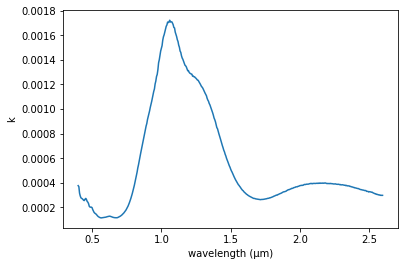

In [50]:
# example

n = 1.83 # real refractive index for olivine
mu = np.cos(np.radians(30)) # cosine of incidence angle
mu_0 = np.cos(np.radians(0)) # cosine of the emergence angle
D = 80 # Grain sizes (in um)

path = "/laboratory-data/mineral-reflectance/c1lr169_15555_olivine.tab"
w, r = importspeclib( syspath + path )
w1, k1 = k(w, r, D, n, 10e-15, 20, 460, 30, 0, 30)


plt.plot(w1, k1)
plt.xlabel('wavelength (µm)')
plt.ylabel('k')